In [5]:
import torch, torchvision
import sys
import random
import json
import torch.nn as nn
import torch.nn.functional as F
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AdamW
from transformers import BertTokenizer, BertModel
# from transformers.models.bert.modeling_bert import BertPreTrainingHeads
from transformers.modeling_bert import BertPreTrainingHeads
from utils import construct_bert_input, PreprocessedADARI_evaluation, save_json, open_json

from fashionbert_model import FashionBert, FashionBertHead
import argparse
import datetime

import numpy as np
from IPython.display import clear_output

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class FashionBert_embedder(transformers.BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config) 
    
        self.bert = BertModel(config)
        self.im_to_embedding = torch.nn.Linear(2048, 768)
        self.im_to_embedding_norm = torch.nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.init_weights()

    def embed(self, embeds, plot_hidden=False):
        
        batch_size = embeds.shape[0]
        seq_length = embeds.shape[1]
        hidden_dim = embeds.shape[2]

        outputs = self.bert(inputs_embeds=embeds, return_dict=True)
        hidden_states = outputs[2]
        
        """
        ----hidden states analyzer--- https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#3-extracting-embeddings
        Number of layers: 13   (initial embeddings + 12 BERT layers)
        Number of batches: 1
        Number of tokens: 512
        Number of hidden units: 768
        """
        # Plot 
        if plot_hidden:
            token_i = 5
            layer_i = 5
            batch_i = 0
            vec = hidden_states[layer_i][batch_i][token_i]
            # Plot the values as a histogram to show their distribution.
            plt.figure(figsize=(10,10))
            plt.hist(vec, bins=200)
            plt.show()
        
        token_embeddings = torch.stack(hidden_states, dim=0) # [13, 1, 512, 768]
        token_embeddings = token_embeddings.squeeze(1)       # [13, 512, 768]
        # Permute to have tokens dimension first
        token_embeddings = token_embeddings.permute(1,0,2)   # [512, 13, 768]

        # hidden states corresponding to the text part
        text_embedding = token_embeddings[:448, :,  :]  # [448, 13, 768]
        # hidden states corresponding to the image part
        image_embedding = token_embeddings[448:, :, :]  # [64, 13, 768]
        print('text embedding shape: ', text_embedding.shape)
        print('image embedding shape: ', image_embedding.shape)

        # Average the second to last hidden layer 
        text_vec = text_embedding[:, -2, :] # [448, 768]
        text_vec = torch.mean(text_vec, dim=0) # [768]
        
        image_vec = image_embedding[:, -2, :] # [64, 768]
        image_vec = torch.mean(image_vec, dim=0) # [768]
        print(type(text_vec))
        
        return text_vec, image_vec
            

def test_embeddings(dataset, device, save_file_name, num_samples = 2, pretrained_model=None):
    torch.cuda.empty_cache()
    torch.manual_seed(0)    
    dataloader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=1, 
        shuffle=False,
        sampler = torch.utils.data.SubsetRandomSampler(
                    torch.randint(high=len(dataset), size=(len(dataset),))),
        )
    print('dataloader len: ', len(dataloader))
    
    if pretrained_model != None:
        embedder = FashionBert_embedder.from_pretrained(pretrained_model, output_hidden_states=True, return_dict=True)
    else:
        embedder = FashionBert_embedder.from_pretrained('bert-base-uncased', output_hidden_states=True, return_dict=True)
    
    embedder.to(device)
    embedder.eval()
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    fashionbert_embeds = dict()
    with torch.no_grad():
        for i, (patches, neg_patches, input_ids, is_paired, attention_mask, neg_input_ids, neg_attention_mask, img_name) in enumerate(dataloader):
            
            inputs = input_ids.squeeze(0).detach().tolist()
            seq = tokenizer.convert_ids_to_tokens(inputs)
            seq = tokenizer.convert_tokens_to_string(seq)
            embeds = construct_bert_input(patches, input_ids, embedder, device)
            text_emb, img_emb = embedder.embed(embeds)
            
            fashionbert_embeds[img_name[0]] = {'text': seq,
                                              'text_emb': text_emb.tolist(),
                                               'img_emb': img_emb.tolist()}
    
    save_json(save_file_name, fashionbert_embeds)
    

In [3]:
dataset = PreprocessedADARI_evaluation('../../../preprocess_adari_evaluation.pkl')

In [ ]:
test_embeddings(dataset, device, 'fashionbert_embeddings.json', 2, '../../../__fashionbert_vanilla_adaptive' )

### CLUSTER

In [7]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.cm as cm
import matplotlib

fashionbert_embeddings_dict = open_json('fashionbert_vanilla_adaptive_embeddings.json')



In [13]:
IMAGE_EMBEDDINGS = []
for k,v in fashionbert_embeddings_dict.items():
    IMAGE_EMBEDDINGS.append(v['img_emb'])

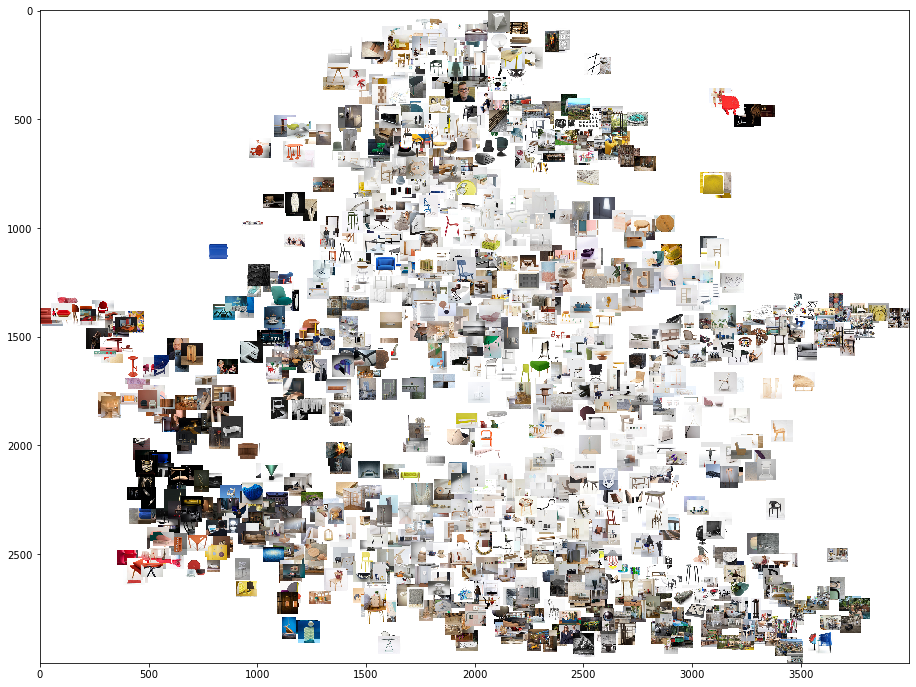

In [18]:
def plot_cluster(im_features):
    #im_embeddings_np = np.asarray(im_features[:1000, :]) # [1000, 2048]
    im_embeddings_np = im_features[:1200, :]
    tsne = TSNE(n_components=2, learning_rate=150).fit_transform(im_embeddings_np)
    return tsne

# im_embds_emb = list(IMAGE_EMBEDDINGS.values()) # embeddings
im_embds_names = list(fashionbert_embeddings_dict.keys()) # embeddings
im_embds_emb = IMAGE_EMBEDDINGS[:1200]

im_embeddings_np = np.asarray(im_embds_emb) # [17532, 50]
tsne = plot_cluster(im_embeddings_np) # [1000, 2]

# Normalize in the range (0,1)
tx, ty = tsne[:, 0], tsne[:, 1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

images = ['/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/images/ADARI_v2/furniture/full' + '/' + im for im in im_embds_names]

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
ii = 0
# font_path = '/System/Library/Fonts/Times.ttc'
# font = PIL.ImageFont.truetype(font_path, size=100)
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
#     draw = ImageDraw.Draw(tile)
#     draw.text((50,50), mc_labels[ii].encode("utf-8").decode("latin1"),fill='black', font=font)
#     tile = tile
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
    ii +=1
matplotlib.pyplot.figure(figsize = (16,12))
matplotlib.pyplot.imshow(full_image)
full_image.save("fashionbert_vanilla_adaptive_embeddings.png")

In [26]:
from matplotlib.pyplot import figure, imshow, axis, savefig
from matplotlib.image import imread
from torchvision.transforms import ToPILImage
from sklearn.neighbors import NearestNeighbors
import warnings

In [27]:
def showImagesHorizontally(list_of_files, save_path=False):
    fig = plt.figure(figsize=(20,20))
    columns = len(list_of_files)
    for i, img in enumerate(list_of_files):
        plt.subplot(len(list_of_files) / columns + 1, columns, i + 1)
        image = imread(list_of_files[i])
        plt.imshow(image)
    if save_path != False:
        fig.savefig(save_path, dpi=300)
   # plt.show()

In [44]:
def nearest_neighbors(dataset, device, num_samples = 2, pretrained_model=None):
    torch.cuda.empty_cache()
    torch.manual_seed(0)    
    dataloader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=1, 
        shuffle=False,
        sampler = torch.utils.data.SubsetRandomSampler(
                    torch.randint(high=len(dataset), size=(len(dataset),))),
        )
    print('dataloader len: ', len(dataloader))
    
    if pretrained_model != None:
        embedder = FashionBert_embedder.from_pretrained(pretrained_model, output_hidden_states=True, return_dict=True)
    else:
        embedder = FashionBert_embedder.from_pretrained('bert-base-uncased', output_hidden_states=True, return_dict=True)
    
    embedder.to(device)
    embedder.eval()
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    
    neigh_im = NearestNeighbors(n_neighbors=10)
    im_embds_name = list(fashionbert_embeddings_dict.keys())
    im_embeddings_np = np.asarray(IMAGE_EMBEDDINGS)
    neigh_im.fit(im_embeddings_np)
    
    total_predictions = 0.0
    correct_predictions = 0.0
    
    predictions = []
    ground_truth = []
    TOTAL_PREDICTED = 0

    im_path_fur = '/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/images/ADARI_v2/furniture/full'
    
    with torch.no_grad():
        for i, (patches, neg_patches, input_ids, is_paired, attention_mask, neg_input_ids, neg_attention_mask, img_name) in enumerate(dataloader):
            if i == 10: break
            inputs = input_ids.squeeze(0).detach().tolist()
            seq = tokenizer.convert_ids_to_tokens(inputs)
            seq = tokenizer.convert_tokens_to_string(seq)
            embeds = construct_bert_input(patches, input_ids, embedder, device)
            text_emb, img_emb = embedder.embed(embeds)
                        
            image =  im_path_fur + '/' + img_name[0]            
            emb_im = np.asarray(img_emb).reshape(1, -1)
            
            d, im_ids = neigh_im.kneighbors(emb_im)
            im_ids = im_ids.squeeze()
            
            imgs = [im_path_fur + '/' + img_name[0]] # first image is the test image 
            
            imgs_labels = []
            
            # get image names + labels of each image
            for imid in im_ids:
                print(imid)
                im_name   =  im_embds_name[imid]
                if im_name == img_name[0]:
                    print('query in neighbors!')
                    continue # if it is the same! 
                
                im_labels = fashionbert_embeddings_dict[im_name]['text']
                imgs_labels.append(im_labels)
                full_path = im_path_fur + '/' + im_name
                imgs.append(full_path)

            print('-----NEW QUERY------')
            print()
            print('true labels: ', seq)
            showImagesHorizontally(imgs, 'fashionbert_vanilla_adaptive_{}.png'.format(i))
            plt.show()
            print()
            print('GT labels of neighboring images')
            print(imgs_labels)
            print()
            print('-----------------------')
            print()


dataloader len:  3539


/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

text embedding shape:  torch.Size([448, 13, 768])
image embedding shape:  torch.Size([64, 13, 768])
<class 'torch.Tensor'>
1745
query in neighbors!
1200
174
125
676
782
2157
2114
251
1487
-----NEW QUERY------

true labels:  [CLS] this is a fairly different approach to what is available on the market so far we wanted to offer an alternative for people who are open to the concept of recycling but do not want the distinctive , rough look such products often have this is all traditional carpentry , so the idea is to use simple , inexpensive technology and craftsmanship and a simple material to create interesting , sustainable pieces with a unique character that are affordable for everybody we decided to emphasise and present these signs of use and the characteristic grain of the pine wood by arranging the boards in geometric patterns of 45 and 90 degrees to each other the inspiration for these patterns originated in the observation of how wooden houses , doors and panelling have been decor

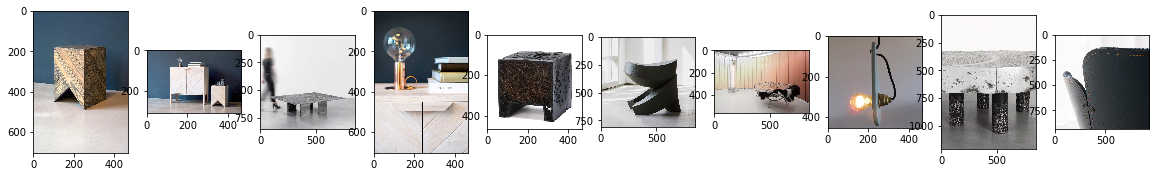


GT labels of neighboring images
["[CLS] this is a fairly different approach to what is available on the market so far we wanted to offer an alternative for people who are open to the concept of recycling but do not want the distinctive , rough look such products often have this is all traditional carpentry , so the idea is to use simple , inexpensive technology and craftsmanship and a simple material to create interesting , sustainable pieces with a unique character that are affordable for everybody we decided to emphasise and present these signs of use and the characteristic grain of the pine wood by arranging the boards in geometric patterns of 45 and 90 degrees to each other the inspiration for these patterns originated in the observation of how wooden houses , doors and panelling have been decorated in northern and eastern europe for centuries these elements are exposed to the elements outdoors and become more vivid over time , which seemed to us a warm and positive example of the

/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

text embedding shape:  torch.Size([448, 13, 768])
image embedding shape:  torch.Size([64, 13, 768])
<class 'torch.Tensor'>
1162
query in neighbors!
2187
54
298
1333
68
1781
1094
1190
430
-----NEW QUERY------

true labels:  [CLS] the speaker inside produces sound waves that shape the surface of the water creating all these different patterns our goal was to make the sound visible , so that ' s the reason for the light the project was inspired by the sounds created by the domestic ritual of cleaning and the repetitive frictions involved the project refers to the humorous aspects of obsession the auscultable is a device that makes the most intimate and hidden sound of the body audible , and that ' s the heartbeat four people sit at the table and they share an intimate moment by listening to each others ' hearts without the heart you wouldn ' t be alive we put the features of a guitar into a cabinet to bring this element of sound into a domestic element the idea was about a couple living t

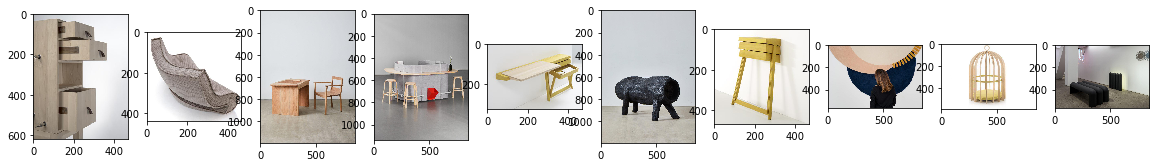


GT labels of neighboring images
["[CLS] the challenge was not to build a traditional sofa with back , seat and armrests , but to start from a single volume , a single piece , and model it to make it as a comfortable as a classic sofa the tub is formed in a sort of cut which shapes the front part of the sofa , outlining soft and welcoming lines , to which a rocking structure can be added to transform the sofa into a swing , combining the experience of movement with comfort the idea came about by accident , after seeing mattresses dumped in the street when walking in town , a sight which captured the boundless imagination of ron arad and triggered an imaginary operation of salvage and decontextualisation matrizia is a sofa - sculpture , an upholstered furniture item which acts as the ideal midway point between design skill and craft talent patrizia turned up and said : ' wow , that ' s nice , can we make it in moroso she was very brave she was fresh from the university of bologna and sh

/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

text embedding shape:  torch.Size([448, 13, 768])
image embedding shape:  torch.Size([64, 13, 768])
<class 'torch.Tensor'>
1798
query in neighbors!
122
50
1863
2054
1219
1484
1970
2198
1140
-----NEW QUERY------

true labels:  [CLS] it ' s something that always fascinated me and ed on the way from south kensington tube up to the royal college when we were students , and so when this project came up we thought it was a nice way to reference that the material is extruded with an oval profile so it has to be cut and put back together again optical illusion edward barber and jay osgerby , jasper morrison and al _ a are among the designers who have created benches with british design brand established & sons for the central courtyard of the v & a museum ( + slideshow ) each of the one - off benches is made from a different material and produced in collaboration with a company specialising in that material edward barber and jay osgerby , the designers of the olympic torch , made a marble benc

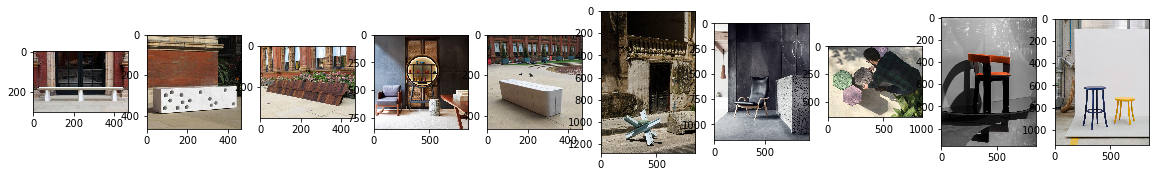


GT labels of neighboring images
["[CLS] it ' s something that always fascinated me and ed on the way from south kensington tube up to the royal college when we were students , and so when this project came up we thought it was a nice way to reference that the material is extruded with an oval profile so it has to be cut and put back together again optical illusion edward barber and jay osgerby , jasper morrison and al _ a are among the designers who have created benches with british design brand established & sons for the central courtyard of the v & a museum ( + slideshow ) each of the one - off benches is made from a different material and produced in collaboration with a company specialising in that material edward barber and jay osgerby , the designers of the olympic torch , made a marble bench with holes bored through ( above ) in collaboration with italian studio tor art they were inspired by shrapnel marks left in the v & a museum ' s western facade after the second world war a

/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

text embedding shape:  torch.Size([448, 13, 768])
image embedding shape:  torch.Size([64, 13, 768])
<class 'torch.Tensor'>
406
query in neighbors!
1794
1035
235
739
1720
1381
1920
382
1405
-----NEW QUERY------

true labels:  [CLS] these knobbly seats by belgian designer maarten de ceulaer are on show at spazio rossana orlandi in milan this week mutation seriesthe pieces in this series look like they weren ’ t made by hands , but have grown to their present form organically they might be the result of a mutation in cells , or the result of a chemical or nuclear reaction the mutation pieces make you look at furniture in a different way on the other hand , the project can be seen as an experimental review of classic furniture upholstery it reminds us of the famous and iconic deep buttoned ( chesterfield ) sofa ' s , interpreted in a highly contemporary and sculptural way in the end the entire piece gets coated , with a durable rubber or tactile velvet - like finish it is hardly possible t

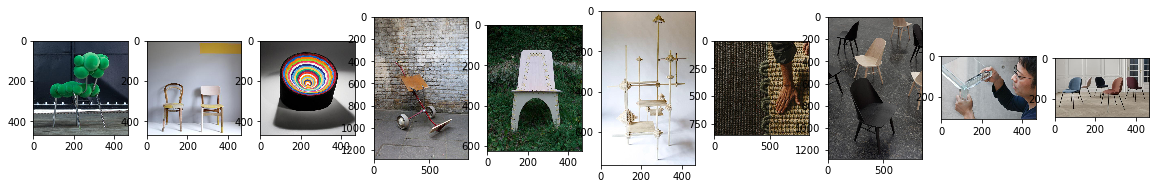


GT labels of neighboring images
["[CLS] south korean designer soojin kang has covered a range of second hand chairs in a patchwork of fabric called patched chair , the square version will be on show at mint shop in london this september today ' s mass - production and the disposable fashion are deeply problematic current fast changing trends and low price that promote consumers to buy more than they need has pushed people to easily throw away their objects dressed chairs are inspired by traditional crafts and antique raw materials , hand made by me ; obviously , the scarcity of the antique funitures used requries the total number of editions produced each piece is exteamly limited each piece is therefore entirely unique dressed chair challeges a new aesthetic statement and it crosses the boundaries of art and design it is important now therefore that we need to consider our basic needs and what we already possess , and to use these materials wisely and beautifully using craft techniqu

/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

text embedding shape:  torch.Size([448, 13, 768])
image embedding shape:  torch.Size([64, 13, 768])
<class 'torch.Tensor'>
2182
query in neighbors!
71
2197
584
2194
2131
942
783
1448
1020
-----NEW QUERY------

true labels:  [CLS] scroll on for the hottest launches from international furniture brands at salone internazionale del mobile , lighting firms at euroluce and young designers at salonesatellite , plus an installation on office design by jean nouvel at salone ufficio internazionale del mobilerem koolhaas ' firm oma created the scenography for american brand knoll , with sheer white curtains encircling the new range of sofas by londoners barberosgerby ( above ) moroso ' s colourful stand based on a tangram puzzle was devised by patricia urquiola and features three new products by the spanish designer , including the felt mafalda chair and the mathilda chair with a backrest wrapped in natural rushes ( above ) other highlights in the extensive new collection include a modular furnit

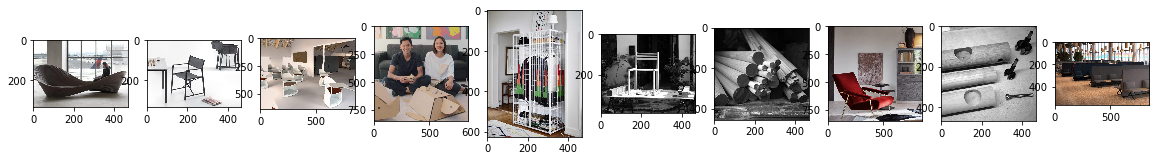


GT labels of neighboring images
["[CLS] scroll on for the hottest launches from international furniture brands at salone internazionale del mobile , lighting firms at euroluce and young designers at salonesatellite , plus an installation on office design by jean nouvel at salone ufficio internazionale del mobilerem koolhaas ' firm oma created the scenography for american brand knoll , with sheer white curtains encircling the new range of sofas by londoners barberosgerby ( above ) moroso ' s colourful stand based on a tangram puzzle was devised by patricia urquiola and features three new products by the spanish designer , including the felt mafalda chair and the mathilda chair with a backrest wrapped in natural rushes ( above ) other highlights in the extensive new collection include a modular furniture system called bikini island by werner aisslinger ( pictured top ) and a rounded chair called dumbo by polish designer tomek rygalik ( above ) the magis stand packs in prototypes of a la

/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

text embedding shape:  torch.Size([448, 13, 768])
image embedding shape:  torch.Size([64, 13, 768])
<class 'torch.Tensor'>
125
query in neighbors!
1200
251
243
2000
1745
676
2172
1706
930
-----NEW QUERY------

true labels:  [CLS] this is a fairly different approach to what is available on the market so far we wanted to offer an alternative for people who are open to the concept of recycling but do not want the distinctive , rough look such products often have this is all traditional carpentry , so the idea is to use simple , inexpensive technology and craftsmanship and a simple material to create interesting , sustainable pieces with a unique character that are affordable for everybody we decided to emphasise and present these signs of use and the characteristic grain of the pine wood by arranging the boards in geometric patterns of 45 and 90 degrees to each other the inspiration for these patterns originated in the observation of how wooden houses , doors and panelling have been decor

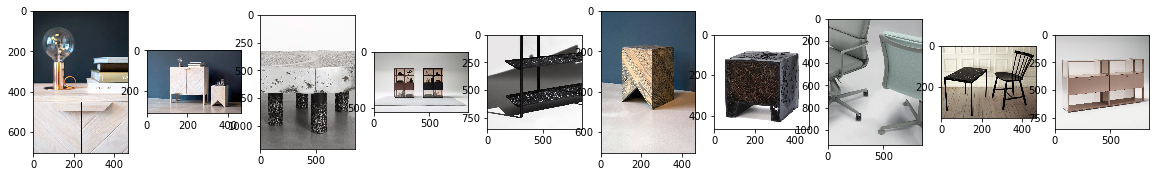


GT labels of neighboring images
["[CLS] this is a fairly different approach to what is available on the market so far we wanted to offer an alternative for people who are open to the concept of recycling but do not want the distinctive , rough look such products often have this is all traditional carpentry , so the idea is to use simple , inexpensive technology and craftsmanship and a simple material to create interesting , sustainable pieces with a unique character that are affordable for everybody we decided to emphasise and present these signs of use and the characteristic grain of the pine wood by arranging the boards in geometric patterns of 45 and 90 degrees to each other the inspiration for these patterns originated in the observation of how wooden houses , doors and panelling have been decorated in northern and eastern europe for centuries these elements are exposed to the elements outdoors and become more vivid over time , which seemed to us a warm and positive example of the

/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

text embedding shape:  torch.Size([448, 13, 768])
image embedding shape:  torch.Size([64, 13, 768])
<class 'torch.Tensor'>
1628
query in neighbors!
1420
253
1206
1653
547
608
988
1473
1201
-----NEW QUERY------

true labels:  [CLS] milan 2011 : french designer matali crasset will present this chair with a fold - out table for italian brand danese in milan next month called double side , the seat is designed so the backrest slides up and flips 90 degrees to become a table surface for writing , using a laptop or eating double side , matali crasset 2011seat natural wood , orange laminate , beige , blue , orange or green felt “ t generous enough if it has just a single function ” ( m double side is a versatile seat which can be transformed with a tiny intuitive gesture , into a work tool , the back flips and becomes a small plane on which you can write , use your computer , eat or play it ’ s a new typology of products which breaks the codes of traditional living based on the idea of life b

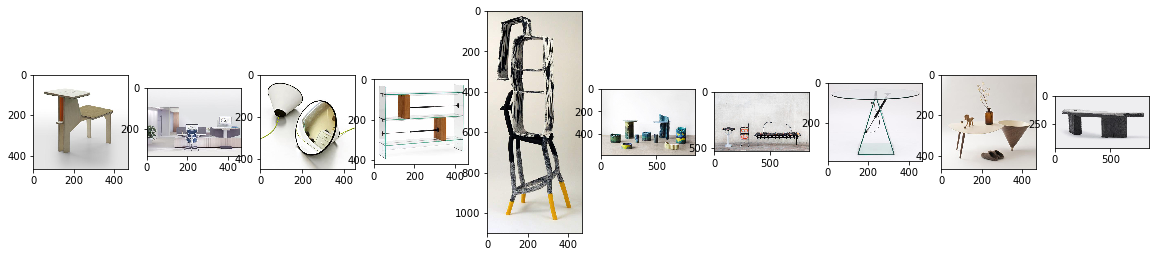


GT labels of neighboring images
["[CLS] one could argue that collaboration is a buzzword right now , that somehow it might go away , but we think this is unimaginable people are collaborating globally , empowered by digital networks , but the most ambitious businesses still need productive , collaborative physical environments we often talk about how social networks behave given current technology , where close relationships are not based on physical proximity , but instead on similarity of purpose or interest you might make an alliance in a social network with someone who is very far away they are great spatial condensers in this respect locale is a physical manifestation of this principle , where the most relevant participants are kept close and communication is fast and frequent we find a lot of value in our own office , which is small , highly productive and considerate we are all from different parts of the world , which says a lot about how the free movement of people has create

/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

text embedding shape:  torch.Size([448, 13, 768])
image embedding shape:  torch.Size([64, 13, 768])
<class 'torch.Tensor'>
879
query in neighbors!
1554
44
927
567
210
2139
801
1471
1987
-----NEW QUERY------

true labels:  [CLS] with 67 per cent of attendees from abroad , most of them high profile and with robust spending power , according to comments from exhibitors , this edition has yet again confirmed the strong international vocation and importance of exports as a crucial segment of the sector today we could be having a conversation or a meal and someone could be sat next to us working on their laptop , and we wouldn ' t feel it ' s weird utilising a new material , the chair represents a significant advancement in the appearance and functionality of this typology generics ' are things that we no longer see because they have become hidden or so integrated into our lives smaller sibling we are always interested in seemingly mundane and anonymous everyday objects this hanger represent

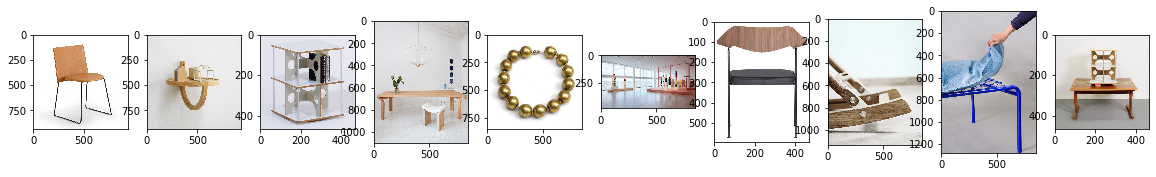


GT labels of neighboring images
["[CLS] with 67 per cent of attendees from abroad , most of them high profile and with robust spending power , according to comments from exhibitors , this edition has yet again confirmed the strong international vocation and importance of exports as a crucial segment of the sector today we could be having a conversation or a meal and someone could be sat next to us working on their laptop , and we wouldn ' t feel it ' s weird utilising a new material , the chair represents a significant advancement in the appearance and functionality of this typology generics ' are things that we no longer see because they have become hidden or so integrated into our lives smaller sibling we are always interested in seemingly mundane and anonymous everyday objects this hanger represents an object that is neglected and ignored in domestic and office environments ) not glorified at all but in fact among the most important this was a bumper year for the salone del mobile 

/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

text embedding shape:  torch.Size([448, 13, 768])
image embedding shape:  torch.Size([64, 13, 768])
<class 'torch.Tensor'>
1957
query in neighbors!
1396
430
298
512
342
210
333
931
2187
-----NEW QUERY------

true labels:  [CLS] we think of products rather than people , we show them in spaces that in the end are truly empty , and we cannot hold people ' s attention to allow them to reflect and think about what they saw of course , we could remain frustrated and do nothing about it , but with a little courage and help , we created something that communicates earnestly and at a very personal level communication , and emotion , is vital for our industry a stockholm apartment once owned by abba ' s manager has been dressed with all - new furniture and used to stage an intimate theatrical performance portuguese brand de la espada has installed its entire new collection inside the early 20th - century flat , which was once the home of stig anderson this never happened , an hour - long perform

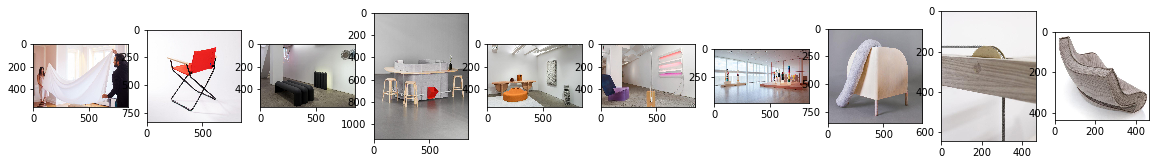


GT labels of neighboring images
["[CLS] a lot of the customers we were targeting live in nice apartments but don ' t have lots of space so it ' s useful for them to own flexible furniture that looks good on a terrace but can also work inside british designer samuel wilkinson has updated the classic director ' s chair , introducing a hidden mechanism that allows the fabric seat to be held in tension without any noticeable support the london - based designer created the prop chair for the conran shop , which tasked him with creating a folding chair with a simple aesthetic that could be used indoors and outdoors due to the retailer ' s customer base being focused around its main locations in london and paris , the project was driven by the needs of high - end urban consumers the prop chair aims for a cleaner aesthetic than existing fabric folding - chairs , which typically feature horizontal struts that lock in place to push the two sides of the frame apart and maintain tension in the se

/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

text embedding shape:  torch.Size([448, 13, 768])
image embedding shape:  torch.Size([64, 13, 768])
<class 'torch.Tensor'>
435
query in neighbors!
907
833
1901
430
1601
1520
593
1537
148
-----NEW QUERY------

true labels:  [CLS] the relationship with earth stations is that everything becomes an independent object the space is no longer a co - ordinated space , but is like a museum with an exposition of different sculptures and different artworks the traditional and conventional way to design today is no longer appropriate to fulfil the imagination and the needs of the people of the future architect and artist michele de lucchi explains how his takeover of poltrona frau ' s flagship store during milan design week explores new ways of working and learning , in this movie dezeen produced for the italian brand these zones are delineated by wooden screens , which are intended to add depth to the rooms whilst also creating privacy the showroom is intended to be a prototype realisation of thi

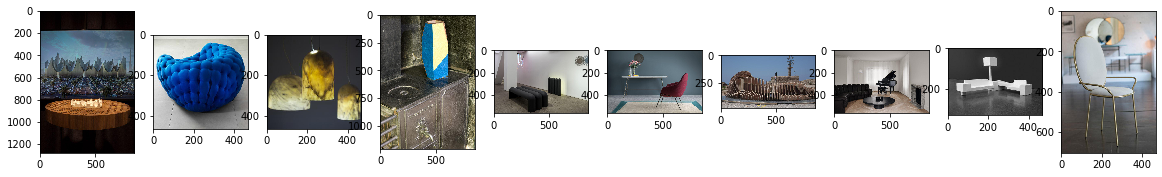


GT labels of neighboring images
['[CLS] austrian designer robert stadler presents new work at carpenters workshop gallery in london stadler continues to challenge the viewer to question the established ideals of traditional design , by paying homage to jean royere , and by examining the possibility that lies between the perception of the artifact and its conceptual interpretation through his innovative collections royere ’ s classic furniture design “ ours polaire ” in his “ ours polaire ” series royere sought to unify the various elements of a seat in order to form an abstract whole this method has produced furniture with a sculptural quality in creating the royeroid series , stadler continues on royere ’ s ‘ quest for abstraction ’ up to a point in which the object turns monolithical , appearing as if it was a three - dimensional computer mesh , whilst maintaining an entirely handmade creation the technically complex work utilizes a combination of traditional artisanal furniture cra

/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(patches).view(patches.shape[0], patches.shape[1]), # [64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(neg_patches), # [NUM_SAMPLES, 64, 2048]
/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/github/ADARI_disentangling_design_intents/multimodal/fashionbert/utils.py:254: UserWarning: To co

In [45]:
nearest_neighbors(dataset, device, 2, '../../../__fashionbert_vanilla_adaptive' )